<a href="https://colab.research.google.com/github/fengtastics/111-Capstone/blob/master/Arterra_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3

#https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

#https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

In [11]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
from numpy import log
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib

from fbprophet import Prophet

matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'

In [8]:
#raw_df = pd.read_csv("C:\\Users\\mcinn\\Documents\\timeseries_vqa.csv")
raw_df = pd.read_csv(
   "timeseries_vqa.csv",      # relative python path to subdirectory
    usecols=[ "AWC Fiscal Year Month Abbr",	"Brand","Varietal Group", 
    "9L Cases","Avg Sales Price","Sales Dollars"],  # Only load the columns specified.
   )

raw_df.head()
#raw_df.info()

,AWC Fiscal Year Month Abbr,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,F2017 FEB,BLACK SAGE VINEYARD,CABERNET FRANC,17,$28.74,"5,912"
1,F2017 FEB,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1,$28.74,368
2,F2017 FEB,BLACK SAGE VINEYARD,MERLOT,11,$28.74,"3,698"
3,F2017 FEB,BLACK SAGE VINEYARD,OTHER,2,$29.89,909
4,F2017 FEB,CULMINA,CHARDONNAY,0,$41.50,85


In [9]:
# replace Sales Dollar , 9L Cases to NUMBERS format

raw_df['Sales Dollars'] = raw_df['Sales Dollars'].str.replace(',', '').astype(float)
raw_df['9L Cases'] = raw_df['9L Cases'].str.replace(',', '').astype(float)
raw_df['Avg Sales Price'] = raw_df['Avg Sales Price'].str.replace('$', '').astype(float)
raw_df.head()



,AWC Fiscal Year Month Abbr,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,F2017 FEB,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
1,F2017 FEB,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1.0,28.74,368.0
2,F2017 FEB,BLACK SAGE VINEYARD,MERLOT,11.0,28.74,3698.0
3,F2017 FEB,BLACK SAGE VINEYARD,OTHER,2.0,29.89,909.0
4,F2017 FEB,CULMINA,CHARDONNAY,0.0,41.50,85.0


In [13]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3671 entries, 0 to 3670
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AWC Fiscal Year Month Abbr  3671 non-null   object 
 1   Brand                       3671 non-null   object 
 2   Varietal Group              3671 non-null   object 
 3   9L Cases                    3671 non-null   float64
 4   Avg Sales Price             3217 non-null   float64
 5   Sales Dollars               3671 non-null   float64
dtypes: float64(3), object(3)
memory usage: 172.2+ KB


In [14]:
raw_df = raw_df.rename({'AWC Fiscal Year Month Abbr': 'Date'}, axis=1) 
raw_df['Date'] = raw_df['Date'].str[1:]
raw_df.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,2017 FEB,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
1,2017 FEB,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1.0,28.74,368.0
2,2017 FEB,BLACK SAGE VINEYARD,MERLOT,11.0,28.74,3698.0
3,2017 FEB,BLACK SAGE VINEYARD,OTHER,2.0,29.89,909.0
4,2017 FEB,CULMINA,CHARDONNAY,0.0,41.50,85.0


In [15]:
import datetime
raw_df['Date'] = pd.to_datetime(raw_df['Date'])
raw_df.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,2017-02-01,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
1,2017-02-01,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1.0,28.74,368.0
2,2017-02-01,BLACK SAGE VINEYARD,MERLOT,11.0,28.74,3698.0
3,2017-02-01,BLACK SAGE VINEYARD,OTHER,2.0,29.89,909.0
4,2017-02-01,CULMINA,CHARDONNAY,0.0,41.50,85.0


In [16]:
raw_df['Date'].min(), raw_df['Date'].max()

(Timestamp('2017-02-01 00:00:00'), Timestamp('2021-10-01 00:00:00'))

In [17]:
raw_df['Varietal Group'].unique()


array(['CABERNET FRANC', 'CABERNET SAUVIGNON', 'MERLOT', 'OTHER',
       'CHARDONNAY', 'RED BLEND', 'RIESLING', 'VIDAL', 'PINOT NOIR',
       'CHENIN BLANC', 'PINOT BLANC', 'PINOT GRIGIO', 'SHIRAZ',
       'ZINFANDEL', 'WHITE BLEND', 'SAUVIGNON BLANC', 'VIOGNIER', 'ROSE',
       'GEWURZTRAMINER', 'TEMPRANILLO', 'MALBEC', 'UNASSIGNED'],
      dtype=object)

In [28]:
#cabernet_franc = raw_df.loc[raw_df['Varietal Group'] == 'CABERNET FRANC']
cabernet_sav = raw_df.loc[raw_df['Varietal Group'] == 'CABERNET SAUVIGNON']
#merlot = raw_df.loc[raw_df['Varietal Group'] == 'MERLOT']
#chardonnay = raw_df.loc[raw_df['Varietal Group'] == 'CHARDONNAY']
red_blend = raw_df.loc[raw_df['Varietal Group'] == 'RED BLEND']
#riesling = raw_df.loc[raw_df['Varietal Group'] == 'RIESLING']
#vidal = raw_df.loc[raw_df['Varietal Group'] == 'VIDAL']
#pinot_noir = raw_df.loc[raw_df['Varietal Group'] == 'PINOT NOIR']
#chenin_blanc = raw_df.loc[raw_df['Varietal Group'] == 'CHENIN BLANC']
#pinot_blanc = raw_df.loc[raw_df['Varietal Group'] == 'PINOT BLANC']
#pinot_grigio = raw_df.loc[raw_df['Varietal Group'] == 'PINOT GRIGIO']
shiraz = raw_df.loc[raw_df['Varietal Group'] == 'SHIRAZ']
#zinfandel = raw_df.loc[raw_df['Varietal Group'] == 'ZINFANDEL']
#white_blend = raw_df.loc[raw_df['Varietal Group'] == 'WHITE BLEND']
#sav_blanc = raw_df.loc[raw_df['Varietal Group'] == 'SAUVIGNON BLANC']
#viognier = raw_df.loc[raw_df['Varietal Group'] == 'VIOGNIER']
rose = raw_df.loc[raw_df['Varietal Group'] == 'ROSE']
gewurz = raw_df.loc[raw_df['Varietal Group'] == 'GEWURZTRAMINER']
#tempranillo = raw_df.loc[raw_df['Varietal Group'] == 'TEMPRANILLO']
#malbec = raw_df.loc[raw_df['Varietal Group'] == 'MALBEC']
#unassigned = raw_df.loc[raw_df['Varietal Group'] == 'UNASSIGNED']
#other = raw_df.loc[raw_df['Varietal Group'] == 'OTHER']

### TRY 1 Varietal group

In [19]:
rose.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
54,2017-02-01,NKMIP,ROSE,0.0,20.69,17.0
132,2018-03-01,NKMIP,ROSE,0.0,NaN,0.0
212,2018-04-01,NKMIP,ROSE,0.0,NaN,0.0
292,2018-05-01,NKMIP,ROSE,0.0,NaN,0.0
327,2018-06-01,CULMINA,ROSE,13.0,23.91,3586.0


In [20]:
varietal = rose
#cols = ['BC Sales Channel',	'AWC and Comp',  'AWC FYr & Pd No',	'Avg Sales Price']
#varietal.drop(cols, axis=1, inplace=True)
varietal = varietal.sort_values('Date')
varietal.isnull().sum()

Date                0
Brand               0
Varietal Group      0
9L Cases            0
Avg Sales Price    14
Sales Dollars       0
dtype: int64

In [21]:
varietal.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
54,2017-02-01,NKMIP,ROSE,0.0,20.69,17.0
923,2018-01-01,NKMIP,ROSE,0.0,NaN,0.0
883,2018-01-01,CULMINA,ROSE,0.0,22.99,46.0
1007,2018-02-01,NKMIP,ROSE,0.0,NaN,0.0
958,2018-02-01,CULMINA,ROSE,1.0,22.99,230.0


In [22]:
# Sum () Unit sold of different Brands for each varietal

varietal_qty= varietal.groupby(['Date'])['9L Cases'].sum().reset_index()
varietal_qty = varietal_qty.sort_values(by="Date",ascending=True)
varietal_qty.head()


,Date,9L Cases
0,2017-02-01,0.0
1,2018-01-01,0.0
2,2018-02-01,1.0
3,2018-03-01,0.0
4,2018-04-01,0.0


In [23]:
df=varietal_qty
df.head()

,Date,9L Cases
0,2017-02-01,0.0
1,2018-01-01,0.0
2,2018-02-01,1.0
3,2018-03-01,0.0
4,2018-04-01,0.0


In [ ]:
## Not sure if we need this step: 

In [ ]:
#df = df.set_index('ds')
#df.index
#df.index


In [ ]:
#y=varietal_qty
#y.head(5)

In [ ]:
#df = df.rename(columns={'Date':'ds', '9L Cases':'y'})

#df.head(5)

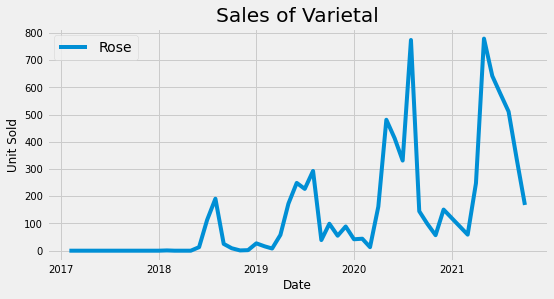

In [24]:
#df.plot(figsize=(18, 8))
#plt.show()

plt.figure(figsize=(8, 4))
plt.plot(df['Date'], df['9L Cases'],  label = 'Rose')

plt.xlabel('Date'); plt.ylabel('Unit Sold'); plt.title('Sales of Varietal')
plt.legend();

In [32]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['9L Cases'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

KeyError: ignored

In [33]:
df = df.rename(columns={'Date': 'ds', '9L Cases': 'y'})
df.head()

,ds,y
0,2017-02-01,0.0
1,2018-01-01,0.0
2,2018-02-01,1.0
3,2018-03-01,0.0
4,2018-04-01,0.0


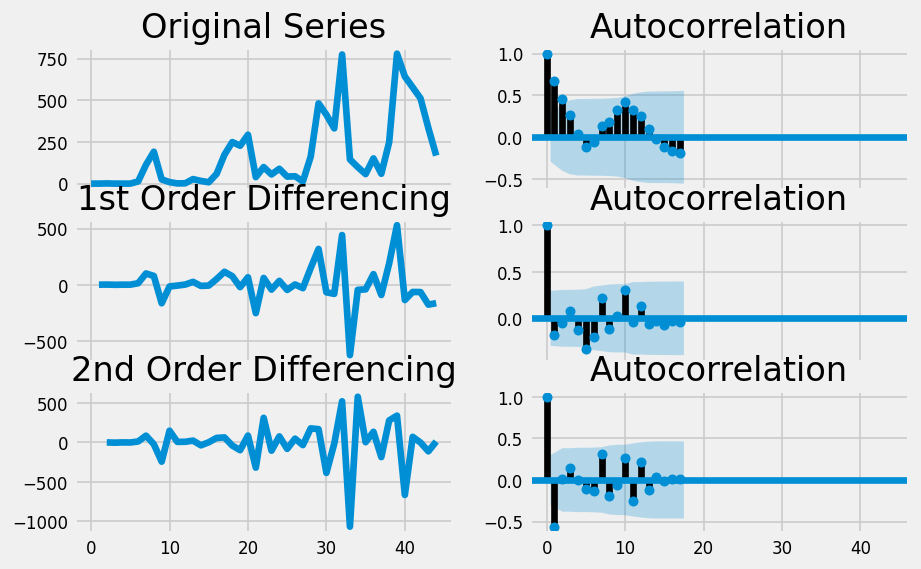

In [34]:
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.y); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(df.y, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.y.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.y.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.y.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.y.diff().diff().dropna(), ax=axes[2, 1])

## we need *2nd* order differencing


plt.show()

In [ ]:
# 2nd order diff
#????????????  not sure if we neeed this for Prophet  #####

#df.y=df.y.diff()

In [ ]:
## Prophet Begins Here ##

In [35]:
# prophet defaults to 80% interval.  
# set up holidays  https://github.com/dr-prodigy/python-holidays

Varietal_model = Prophet(interval_width=0.80)
Varietal_model = Varietal_model.add_country_holidays(country_name='CA')
Varietal_model.train_holiday_names

In [41]:
Varietal_model.train_holiday_names

0                New Year's Day
1     New Year's Day (Observed)
2                   Good Friday
3                  Victoria Day
4                    Canada Day
5         Canada Day (Observed)
6                    Labour Day
7                  Thanksgiving
8               Remembrance Day
9                 Christmas Day
10                   Boxing Day
11        Boxing Day (Observed)
12     Christmas Day (Observed)
dtype: object

In [37]:

Varietal_model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
# Frequency  = M monthly;  MS month start !?

Varietal_forecast = Varietal_model.make_future_dataframe(periods=24, freq='MS')

#predict
Varietal_forecast = Varietal_model.predict(Varietal_forecast)

In [39]:
#forecasted value
Varietal_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
64,2023-06-01,763.394610,668.973322,862.205104
65,2023-07-01,783.979886,687.549106,873.713323
66,2023-08-01,754.952616,662.826840,851.946613
67,2023-09-01,607.998663,513.100427,701.558617
68,2023-10-01,626.224457,530.964121,726.084928


In [76]:
m = Prophet(seasonality_mode='multiplicative',
                interval_width=0.95).fit(df)

future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)

forecast = forecast[['ds','yhat_lower', 'yhat', 'yhat_upper']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [78]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='900 days', period='60 days', horizon = '90 days')


INFO:fbprophet:Making 12 forecasts with cutoffs between 2019-09-12 00:00:00 and 2021-07-03 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [79]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-01,375.286681,374.558173,376.008508,99.0,2019-09-12
1,2019-11-01,387.694538,386.966924,388.408027,55.0,2019-09-12
2,2019-12-01,-483.948315,-484.650639,-483.239556,89.0,2019-09-12
3,2019-12-01,135.241734,134.502832,136.028495,89.0,2019-11-11
4,2020-01-01,103.565056,102.763940,104.405137,42.0,2019-11-11


In [80]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,22 days,513767.031935,716.775440,435.165902,2.867816,0.519570,0.000000
1,23 days,783138.406605,884.951076,719.798732,3.421131,2.179516,0.000000
2,24 days,527141.884642,726.045374,523.221997,2.091001,2.179516,0.333333
3,25 days,274743.092053,524.159415,350.442005,1.118395,1.124121,0.333333
4,26 days,13521.869118,116.283572,104.748791,0.751847,1.079871,0.333333


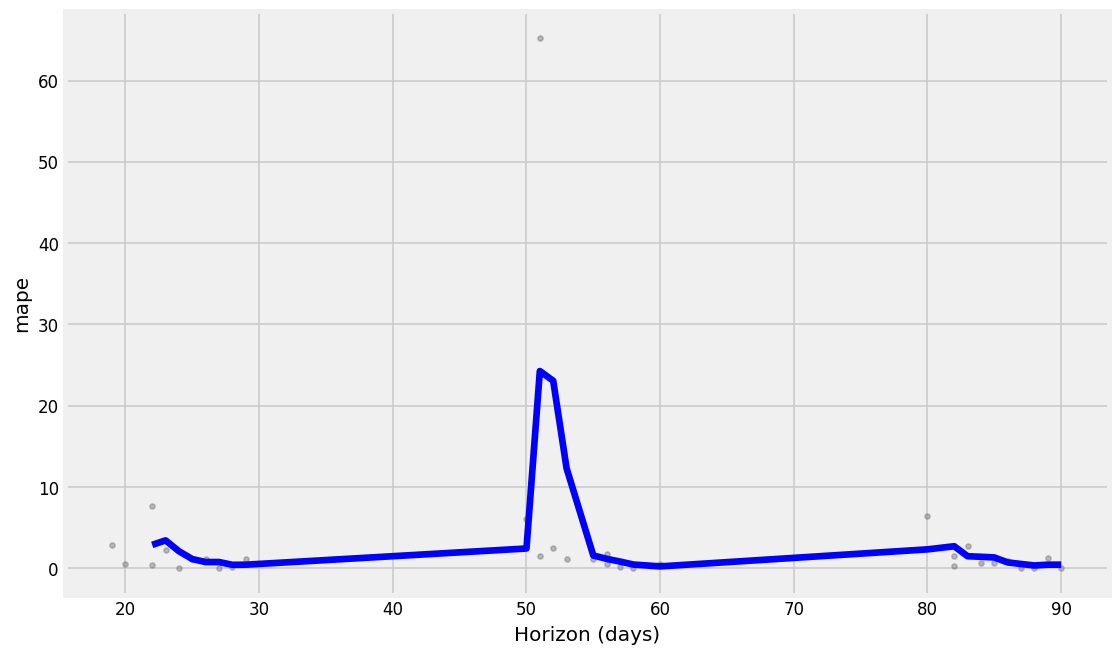

In [81]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [40]:
#fb prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(Varietal_model, Varietal_forecast)

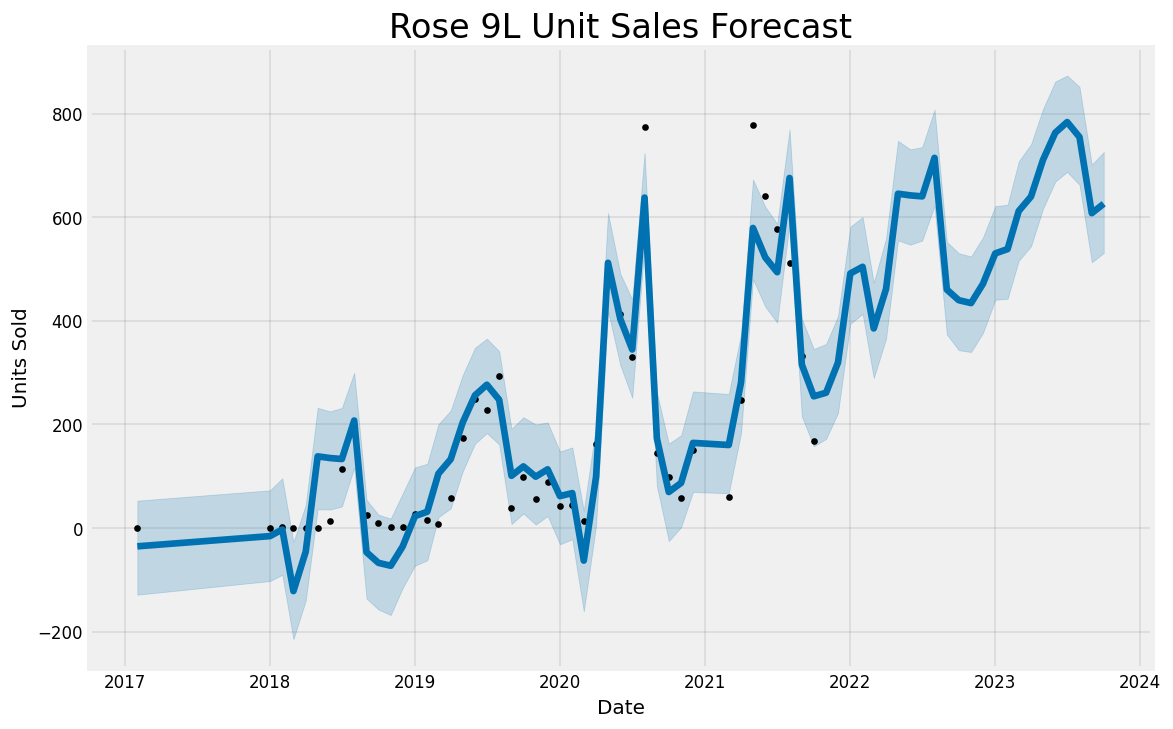

In [42]:
#plt.figure(figsize=(6, 3))

Varietal_model.plot(Varietal_forecast, xlabel = 'Date', ylabel = 'Units Sold')
plt.title('Rose 9L Unit Sales Forecast');

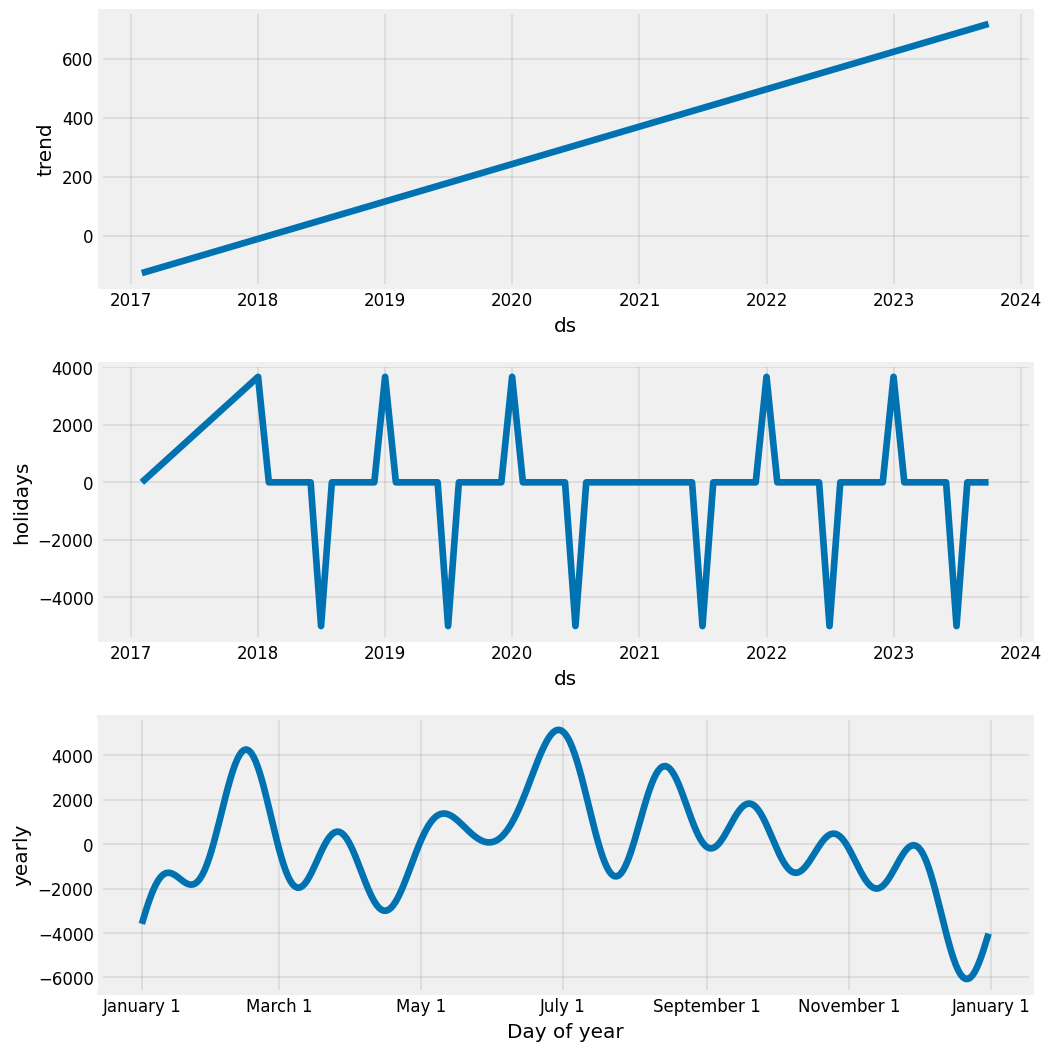

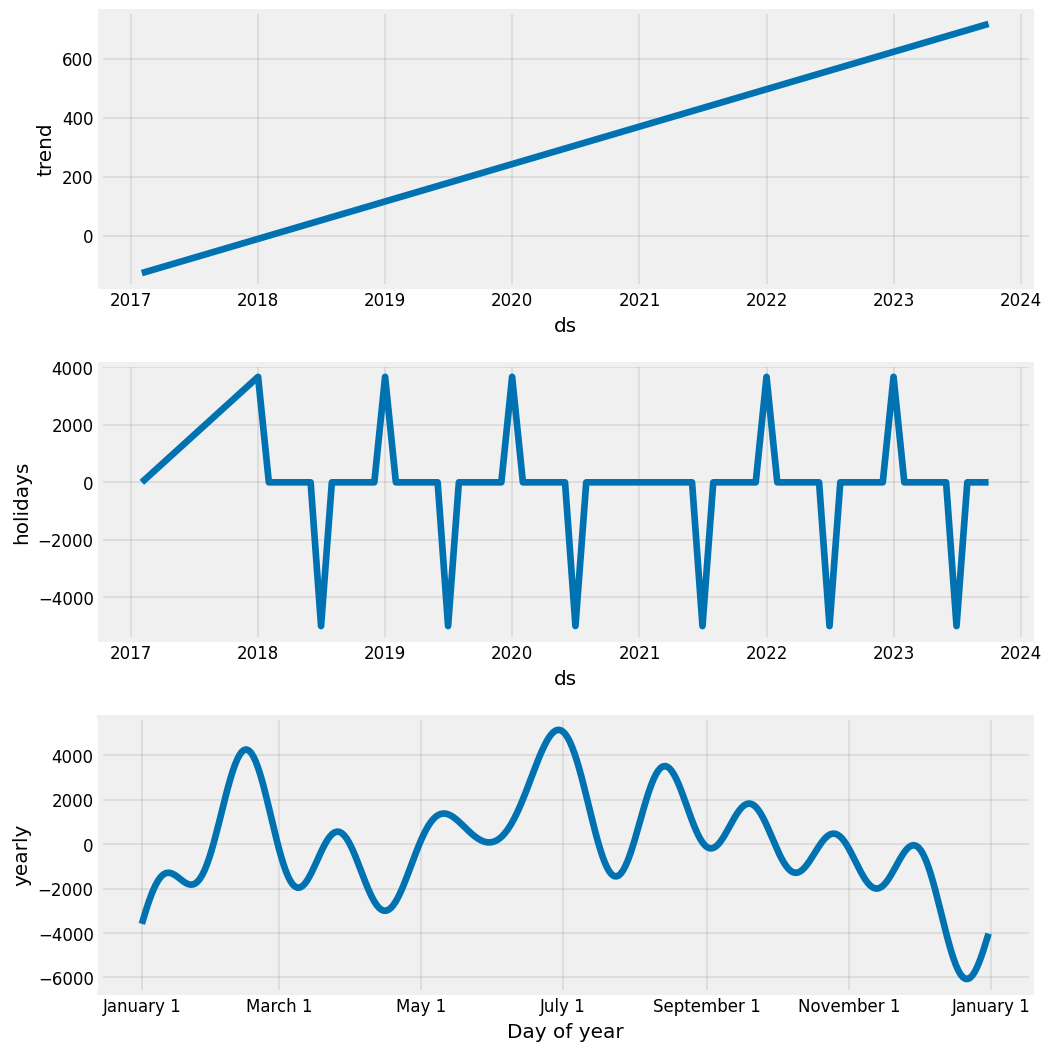

In [43]:
Varietal_model.plot_components(Varietal_forecast)

TypeError: ignored